# Following the low level tutorial guide
This code is currently looking at this IRIS observation:

DST flare watch coordination, 2014-10-25 14:58:28-18:00:56

OBS 3880106953: Large sit-and-stare

https://www.lmsal.com/hek/hcr?cmd=view-event&event-id=ivo%3A%2F%2Fsot.lmsal.com%2FVOEvent%23VOEvent_IRIS_20141025_145828_3880106953_2014-10-25T14%3A58%3A282014-10-25T14%3A58%3A28.xml

In [1]:
%matplotlib inline
import gzip
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import pandas as pd
# Set up some default matplotlib options
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'inferno'

## RASTER FILES

In [2]:
# opens the IRIS fits file
sp = fits.open("20141025raster.fits")

In [3]:
# doublecheck what type of observation we have
hd = sp[0].header
hd['OBS_DESC']

'Large sit-and-stare 0.3x120 1s  C II   Mg II h/k   Mg II w Deep x 4'

In [4]:
# print name & index of each spectral line
print('Window. Name      : wave start - wave end\n')
for i in range(hd['NWIN']):
    win = str(i + 1)
    print('{0}. {1:15}: {2:.2f} - {3:.2f} Å'
          ''.format(win, hd['TDESC' + win], hd['TWMIN' + win], hd['TWMAX' + win]))

Window. Name      : wave start - wave end

1. C II 1336      : 1331.69 - 1358.32 Å
2. Si IV 1394     : 1380.77 - 1406.70 Å
3. Mg II k 2796   : 2783.32 - 2834.96 Å


In [5]:
# Set which line to look at
line_num = 2

In [6]:
# changing this value to 1 was necessary to use the wcs transformation code (something to do with making sure the transformation matrix is non-singular)
# however I don't think we even need actual Sun coords anwyway
if sp[line_num].header['CDELT3']==0:
    sp[line_num].header['CDELT3']=1

In [7]:
# This code is sorcery I don't understand that gets us the wavelength information
wcs = WCS(sp[line_num].header)
m_to_nm = 1e9  # convert wavelength to nm
nwave = sp[line_num].data.shape[2]
wavelength = wcs.all_pix2world(np.arange(nwave), [0.], [0.], 0)[0] * m_to_nm

# Spectroheliograms

In [8]:
# The position of the 1393.757 Å line
line_index_1394 = np.argmin(np.abs(wavelength - 139.3757))
print(line_index_1394)

510


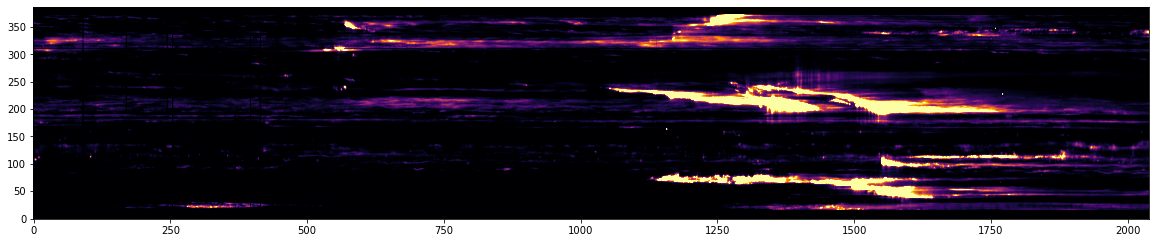

In [9]:
# plot the brightness in the 1394 line. y axis = slit position, x axis = time
plt.figure(figsize=(20, 20))

plt.imshow(sp[line_num].data[..., line_index_1394].T, vmin=100, vmax=2000)

In [10]:
# Let's get the flare data
temp_data = sp[line_num].data

In [11]:
# create an array containing the timestamps of the data (as strings)
time_diff = sp[-2].data[:, sp[-2].header['TIME']]
times_temp = np.datetime64(hd['DATE_OBS']) + time_diff * np.timedelta64(1, 's')
times_string = np.datetime_as_string(times_temp)
times = []
for letter in np.arange(0, len(times_string)):
    times.append(times_string[letter][11:-4])

# Gaussian Analysis

We want to pick out data points from the above data to perform Gaussian analysis, based on chosen criteria (specific intensity ratio and intensity ranges).

### Gaussian Analysis Test

In [46]:
### which pixel?
test_t = 1717
test_y = 291

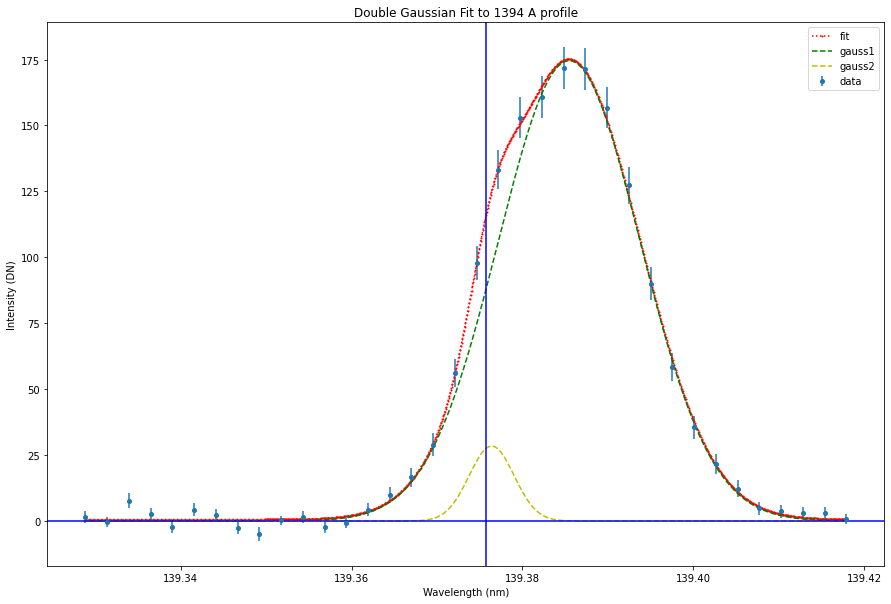

the code ran
the paramaters are:
A1 =  174.5582938871594
mean1 =  139.38546869478648
sigma1 =  0.00830813330727972
A2 =  28.405457539509534
mean2 =  139.3763973719897
sigma2 =  0.002628392855521819
background =  -0.5528073183049649
174.75113738847912
139.38482278687664
the covariances are:  [[ 2.11723125e+01 -5.90411551e-04 -1.29049460e-04 -1.37052669e+01
  -1.15425857e-03 -1.83819727e-03  2.24562195e-01]
 [-5.90411551e-04  7.91987994e-08 -2.05429042e-08  1.26595300e-03
   1.94326324e-08  1.51285050e-07 -2.33974373e-05]
 [-1.29049460e-04 -2.05429042e-08  3.03541244e-08 -4.39024939e-04
   2.67605704e-08 -5.08946413e-08  3.88196456e-05]
 [-1.37052669e+01  1.26595300e-03 -4.39024939e-04  5.87285930e+01
   4.25639135e-04  8.33163352e-04 -5.63237430e-01]
 [-1.15425857e-03  1.94326324e-08  2.67605704e-08  4.25639135e-04
   4.74087886e-07  1.52846444e-07  1.60237198e-05]
 [-1.83819727e-03  1.51285050e-07 -5.08946413e-08  8.33163352e-04
   1.52846444e-07  7.03334950e-07 -5.45570914e-05]
 [ 2.2

In [47]:
# Test on the 1394 line - we need to extract this from the full spectral data
# we use the two line_index variables found previously, but we want to be able to select a specific wavelength range around the reference wavelength

li_1394_upper = np.argmin(np.abs(wavelength - 139.42))
li_1394_lower = np.argmin(np.abs(wavelength - 139.33))

# extract the desired data range
test_gauss_x = wavelength[li_1394_lower:li_1394_upper]
test_gauss_y_32 = sp[line_num].data[test_t, test_y, li_1394_lower:li_1394_upper]
test_gauss_y = test_gauss_y_32.astype(np.float64) # conversion of y data to float64, so it matches the x data
test_y_error = np.sqrt(np.absolute(test_gauss_y)/4)+1.5

# dummy x 
dummytest = np.linspace(np.min(test_gauss_x), np.max(test_gauss_x), 1000)

# Then we can perform a Gaussian fit to the line profile
# initial guesses
mean = 139.3757
sigma = 0.01
background = 1

#def gauss(x,a,x0,sigma,background):
    #return a*np.exp(-(x-x0)**2/(2*sigma**2))-background

    # trying out bimodal code
def gauss(x,A,mu,sigma):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,A1,mu1,sigma1,A2,mu2,sigma2,background):
    return gauss(x,A1,mu1,sigma1)+gauss(x,A2,mu2,sigma2)-background

# Triple Time
def trimodal(x,A1,mu1,sigma1,A2,mu2,sigma2,A3,mu3,sigma3,background):
    return gauss(x,A1,mu1,sigma1)+gauss(x,A2,mu2,sigma2)+gauss(x,A3,mu3,sigma3)-background

# perform the Gaussian fit
popt,pcov = curve_fit(bimodal,test_gauss_x,test_gauss_y, sigma=test_y_error, p0=[max(test_gauss_y), mean, sigma, max(test_gauss_y)*0.8, mean+0.01, sigma, background], maxfev=1000)
#popt,pcov = curve_fit(trimodal,test_gauss_x,test_gauss_y, p0=[max(test_gauss_y), mean, sigma, max(test_gauss_y)*0.1, mean-0.02, sigma, max(test_gauss_y)*0.75, mean+0.01, sigma, background], maxfev=10000)

plt.errorbar(test_gauss_x,test_gauss_y, yerr=test_y_error, fmt='o', ms=4, label='data')
plt.plot(dummytest,bimodal(dummytest,*popt),'or:', ms=1, label='fit')
#plt.plot(test_gauss_x,trimodal(test_gauss_x,*popt),'ro:',label='fit')
plt.plot(dummytest,gauss(dummytest,popt[0],popt[1],popt[2]), '--g', label='gauss1')
plt.plot(dummytest,gauss(dummytest,popt[3],popt[4],popt[5]), '--y', label='gauss2')
#plt.plot(test_gauss_x,gauss(test_gauss_x,popt[6],popt[7],popt[8]), '--c', label='gauss3')
plt.axhline(y=0, color='b', linestyle='-')
plt.axvline(x=139.3757, color='b', linestyle='-')
plt.legend()
plt.title('Double Gaussian Fit to 1394 A profile')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (DN)')
plt.show()
print('the code ran')
print('the paramaters are:')
print('A1 = ', popt[0])
print('mean1 = ', popt[1])
print('sigma1 = ', popt[2])
print('A2 = ', popt[3])
print('mean2 = ', popt[4])
print('sigma2 = ', popt[5])
print('background = ', popt[6])
print(np.max(bimodal(test_gauss_x,*popt)))
print(test_gauss_x[np.argmax(bimodal(test_gauss_x,*popt))])
print('the covariances are: ', pcov)

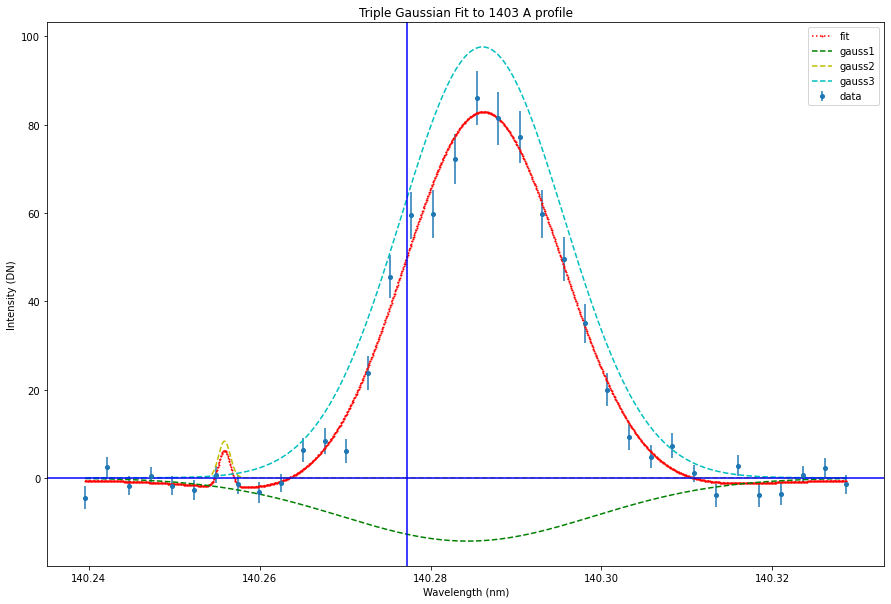

the code ran
[-1.43334774e+01  1.40284312e+02  1.47817578e-02  8.29642327e+00
  1.40255886e+02 -6.84589320e-04  9.76243851e+01  1.40286078e+02
  9.50555065e-03  4.84091007e-01]
[[ 8.45630404e+03 -7.58446660e-01  2.37406752e+00 -1.73776069e+07
  -3.33685529e+02 -4.44416260e+02 -8.61564966e+03  6.21849422e-02
  -1.87743048e-01 -2.21649019e+02]
 [-7.58446660e-01  8.40647979e-05 -2.09655695e-04  1.79113872e+03
   3.43932553e-02  4.58069666e-02  7.73345251e-01 -3.92542107e-06
   1.69267866e-05  1.87251786e-02]
 [ 2.37406752e+00 -2.09655695e-04  6.95779986e-04 -5.09177416e+03
  -9.77719190e-02 -1.30218027e-01 -2.43042037e+00  1.81928385e-05
  -5.09575772e-05 -7.14158877e-02]
 [-1.73776069e+07  1.79113872e+03 -5.09177416e+03  1.49339448e+11
   2.86766170e+06  3.81905162e+06  1.77496157e+07 -1.07873540e+02
   3.59964591e+02  4.28334062e+05]
 [-3.33685529e+02  3.43932553e-02 -9.77719189e-02  2.86766170e+06
   5.50657164e+01  7.33345953e+01  3.40828644e+02 -2.07140931e-03
   6.91208779e-03  8.22

In [48]:
# Test on the 1403 line - we need to extract this from the full spectral data
# we use the two line_index variables found previously, but we want to be able to select a specific wavelength range around the reference wavelength

li_1403_upper = np.argmin(np.abs(wavelength - 140.33))
li_1403_lower = np.argmin(np.abs(wavelength - 140.24))

# extract the desired data range
test_gauss_x = wavelength[li_1403_lower:li_1403_upper]
test_gauss_y_32 = sp[line_num].data[test_t, test_y, li_1403_lower:li_1403_upper]
test_gauss_y = test_gauss_y_32.astype(np.float64) # conversion of y data to float64, so it matches the x data

test_y_error = np.sqrt(np.absolute(test_gauss_y)/4)+1.5

# dummy x 
dummytest = np.linspace(np.min(test_gauss_x), np.max(test_gauss_x), 1000)

# Then we can perform a Gaussian fit to the line profile
# initial guesses
mean = 140.2772
sigma = 0.01
background = 1

    
# perform the Gaussian fit
popt,pcov = curve_fit(trimodal,test_gauss_x,test_gauss_y, p0=[max(test_gauss_y), mean, sigma, max(test_gauss_y)*0.1, mean-0.02, sigma, max(test_gauss_y)*0.75, mean+0.01, sigma, background], maxfev=1000)
          
plt.errorbar(test_gauss_x,test_gauss_y, yerr=test_y_error, fmt='o', ms=4, label='data')
plt.plot(dummytest,trimodal(dummytest,*popt),'ro:', ms=1, label='fit')
plt.plot(dummytest,gauss(dummytest,popt[0],popt[1],popt[2]), '--g', label='gauss1')
plt.plot(dummytest,gauss(dummytest,popt[3],popt[4],popt[5]), '--y', label='gauss2')
plt.plot(dummytest,gauss(dummytest,popt[6],popt[7],popt[8]), '--c', label='gauss3')
plt.axhline(y=0, color='b', linestyle='-')
plt.axvline(x=140.2772, color='b', linestyle='-')
plt.legend()
plt.title('Triple Gaussian Fit to 1403 A profile')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (DN)')
plt.show()
print('the code ran')
print(popt)
print(pcov)

## Loop Code without Chi test

In [49]:
# create the array with 100 x 2040 data points - one for each data point in the area of interest - with columms for:
# time & slit coordinate, max intensity for both lines, a flag for if lines are single Gaussian, and all Gauss info
# the y-coordinate will be zero-based from y = 288 on the spectroheliograph
tripleGaussArray = np.zeros((2040, 85, 21))

# line ranges
li_1394_upper = np.argmin(np.abs(wavelength - 139.42))
li_1394_lower = np.argmin(np.abs(wavelength - 139.33))

li_1403_upper = np.argmin(np.abs(wavelength - 140.33))
li_1403_lower = np.argmin(np.abs(wavelength - 140.24))

# x data
x1394 = wavelength[li_1394_lower:li_1394_upper]
dummyx1394 = np.linspace(np.min(x1394), np.max(x1394), 1000)
x1403 = wavelength[li_1403_lower:li_1403_upper] 
dummyx1403 = np.linspace(np.min(x1403), np.max(x1403), 1000)

# slit positions used
startslit = 288
endslit = 373

# define model
def gauss(x,A,mu,sigma):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,A1,mu1,sigma1,A2,mu2,sigma2,background):
    return gauss(x,A1,mu1,sigma1)+gauss(x,A2,mu2,sigma2)-background

# Triple Time
def trimodal(x,A1,mu1,sigma1,A2,mu2,sigma2,A3,mu3,sigma3,background):
    return gauss(x,A1,mu1,sigma1)+gauss(x,A2,mu2,sigma2)+gauss(x,A3,mu3,sigma3)-background
        
# initial guesses
mean_1394 = 139.3757
mean_1403 = 140.2772
sigma = 0.01
background = 1

gny = 0
success_1394 = 0
success_1403 = 0
for gy in np.arange(startslit, endslit):
    print(gy)
    for gt in np.arange(0, 2040):
        # store coords of this point
        tripleGaussArray[gt, gny, 0] = gt
        tripleGaussArray[gt, gny, 1] = gy
        
        # extract the desired data range
        gauss_y_32 = sp[line_num].data[gt, gy, li_1394_lower:li_1394_upper]
        gauss_y = gauss_y_32.astype(np.float64) # conversion of y data to float64, so it matches the x data
        yError = np.sqrt(np.absolute(gauss_y)/4)+1.5
        #store intensity at this point
        tripleGaussArray[gt, gny, 2] = max(gauss_y)
        
        # perform the Gaussian fit
        try:
            popt,pcov = curve_fit(bimodal,x1394,gauss_y, sigma=yError, p0=[max(gauss_y), mean_1394, sigma, max(gauss_y)*0.75, mean_1394-0.01, sigma, background], maxfev=1000)
            success_1394 = 1
            tripleGaussArray[gt, gny, 5] = np.max(bimodal(dummyx1394,*popt))
            tripleGaussArray[gt, gny, 6] = dummyx1394[np.argmax(bimodal(dummyx1394,*popt))]
            tripleGaussArray[gt, gny, 7] = popt[0]
            tripleGaussArray[gt, gny, 8] = popt[1]
            tripleGaussArray[gt, gny, 9] = popt[3]
            tripleGaussArray[gt, gny, 10] = popt[4]
            tripleGaussArray[gt, gny, 19] = popt[6]
        except:
            success_1394 = 0
        
        if success_1394 == 1:
            #do the fitting for the 1403 line
            gauss_y_32 = sp[line_num].data[gt, gy, li_1403_lower:li_1403_upper]
            gauss_y = gauss_y_32.astype(np.float64) # conversion of y data to float64, so it matches the x data
            yError = np.sqrt(np.absolute(gauss_y)/4)+1.5
            #store intensity at this point
            tripleGaussArray[gt, gny, 3] = max(gauss_y)

            # perform the Gaussian fit
            try:
                popt,pcov = curve_fit(trimodal,x1403,gauss_y, sigma=yError, p0=[max(gauss_y), mean_1403, sigma, max(gauss_y)*0.75, mean_1403-0.01, sigma, max(gauss_y)*0.75, mean_1403+0.01, sigma, background], maxfev=2000)
                success_1403 = 1
                tripleGaussArray[gt, gny, 11] = np.max(trimodal(dummyx1403,*popt))
                tripleGaussArray[gt, gny, 12] = dummyx1403[np.argmax(trimodal(dummyx1403,*popt))]
                tripleGaussArray[gt, gny, 13] = popt[0]
                tripleGaussArray[gt, gny, 14] = popt[1]
                tripleGaussArray[gt, gny, 15] = popt[3]
                tripleGaussArray[gt, gny, 16] = popt[4]
                tripleGaussArray[gt, gny, 17] = popt[6]
                tripleGaussArray[gt, gny, 18] = popt[7]
                tripleGaussArray[gt, gny, 20] = popt[9]
            except:
                success_1403 = 0

        # did the gaussian fitting succeed?
        if success_1394==1 and success_1403==1:
            tripleGaussArray[gt,gny, 4] = 1
        else:
            tripleGaussArray[gt,gny, 4] = 0
        
        success_1394 = 0
        success_1403 = 0
    gny = gny + 1

288


C:\Users\craig\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372


In [50]:
no_of_data=np.count_nonzero(tripleGaussArray[:,:,4] == 1, axis=0)
print(no_of_data)
print('We currently have ', np.sum(no_of_data), ' data points where both profiles are double Gaussian')
resultsArray = tripleGaussArray.reshape(2040*85,21)

[1390 1367 1365 1316 1372 1335 1306 1260 1255 1344 1269 1260 1308 1263
 1268 1307 1240 1215 1266 1385 1398 1376 1411 1296 1461 1473 1449 1419
 1459 1479 1461 1512 1481 1447 1496 1493 1492 1518 1540 1556 1549 1563
 1522 1513 1585 1580 1562 1640 1543 1528 1491 1512 1542 1584 1579 1519
 1456 1496 1534 1451 1432 1384 1399 1422 1425 1397 1394 1402 1410 1412
 1405 1410 1465 1451 1416 1333 1346 1369 1333 1343 1354 1385 1109 1712
 1702]
We currently have  121267  data points where both profiles are double Gaussian


In [51]:
#save data as csv by converting to pandas df
colnames = ['t coord', 'y coord', '1394 int', '1403 int', 'success', '1394g int', '1394g wave', '1394g1 int', '1394g1 wave', '1394g2 int', '1394g2 wave',
            '1403g int', '1403g wave', '1403g1 int', '1403g1 wave', '1403g2 int', '1403g2 wave', '1403g3 int', '1403g3 wave', '1394back', '1403back']
dfgauss = pd.DataFrame(resultsArray, columns=colnames)
dfgauss.to_csv('tripleGaussResults.csv', index=False)